In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Load data from SQL Server
import pyodbc

In [4]:
# Connect to SQL Server
server = 'DESKTOP-TOA5621\SQLEXPRESS'
database = 'SalesDWH'
conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes;')

# Query data
query = "SELECT FORMAT([Date], 'yyyy-MM') AS [Month], SUM([Quantity]) AS [TotalQuantity] FROM [dbo].[FactSales] GROUP BY FORMAT([Date], 'yyyy-MM')"
df = pd.read_sql(query, conn)


C:\Users\User\AppData\Local\Temp\ipykernel_10092\4102793946.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
# Data preprocessing
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.sort_index(inplace=True)


In [6]:
# Close the database connection
conn.close()


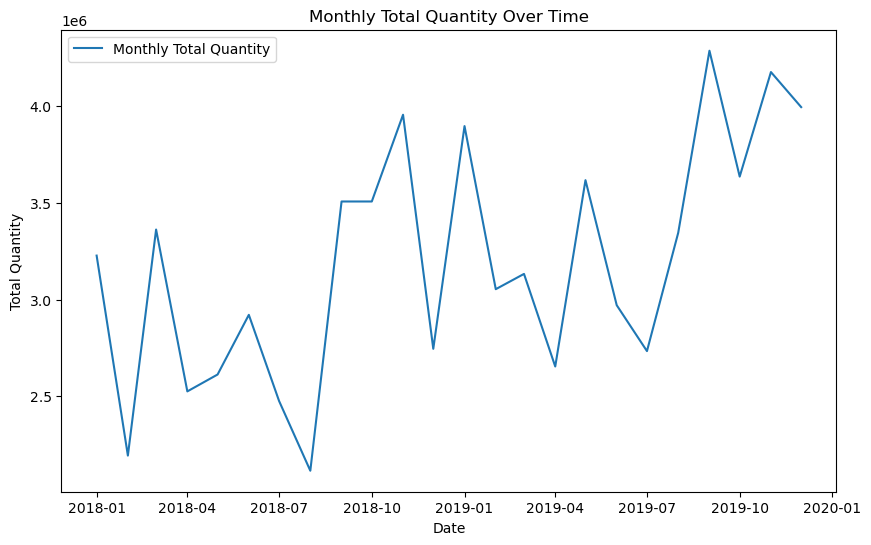

In [7]:
# Plot original data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['TotalQuantity'], label='Monthly Total Quantity')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('Monthly Total Quantity Over Time')
plt.legend()
plt.show()

In [8]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['TotalQuantity']])


In [9]:
# Function to create dataset with sequences
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [10]:
# Generate sequences
look_back = 12  # Adjust look_back period based on model performance and data availability
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [11]:
# Split the data into training and testing sets
split_percent = 0.67
split = int(split_percent * len(X))
trainX, testX = X[:split], X[split:]
trainY, testY = Y[:split], Y[split:]


In [18]:
def create_model(input_shape):
    model = Sequential([
        LSTM(50, input_shape=input_shape, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the model with the correct input shape
input_shape = (trainX.shape[1], 1)  # 'trainX.shape[1]' is your look_back parameter
model = create_model(input_shape)

In [19]:
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=1)


Epoch 1/200

8/8 [==============================] - 5s 12ms/step - loss: 0.2562
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1127
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0360
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0460
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0478
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0404
Epoch 7/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0406
Epoch 8/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0393
Epoch 9/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0454
Epoch 10/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0402
Epoch 11/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0422
Epoch 12/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0405
Epoch 13/200
8/8 [==============================] - 0s 

8/8 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 103/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 104/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0162
Epoch 105/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0189
Epoch 106/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 107/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0230
Epoch 108/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 109/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0183
Epoch 110/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 111/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0168
Epoch 112/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0235
Epoch 113/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0149
Epoch 114/200
8/8 [==============================]

In [20]:
# Make predictions
trainPredict = model.predict(trainX)

1/1 [==============================] - 1s 1s/step


In [21]:
testPredict = model.predict(testX)


1/1 [==============================] - 0s 60ms/step


In [22]:
# Inverse transform predictions and actual values to calculate accuracy
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform([trainY])


In [23]:
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform([testY])

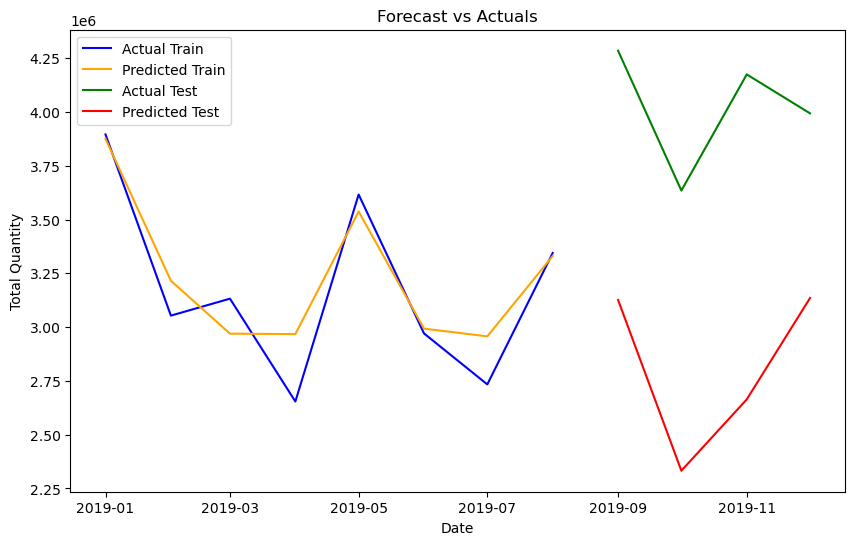

In [24]:
# Plot predictions and actual values for visualization
plt.figure(figsize=(10,6))
plt.plot(df.index[look_back:split+look_back], trainY_actual[0], label='Actual Train', color='blue')
plt.plot(df.index[look_back:split+look_back], trainPredict[:,0], label='Predicted Train', color='orange')
plt.plot(df.index[split+look_back:], testY_actual[0], label='Actual Test', color='green')
plt.plot(df.index[split+look_back:], testPredict[:,0], label='Predicted Test', color='red')
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.legend()
plt.show()

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for training and testing sets
train_mape = mean_absolute_percentage_error(trainY_actual[0], trainPredict[:,0])
test_mape = mean_absolute_percentage_error(testY_actual[0], testPredict[:,0])

print('Train MAPE:', train_mape)
print('Test MAPE:', test_mape)


Train MAPE: 4.292357892700431
Test MAPE: 30.13278687445767


In [26]:
# Setup the initial state for the forecast
look_back = 12  # Ensure this matches your model's training configuration
last_known_index = len(df) - 1
forecast_steps = 12  # Total months to forecast (last 6 months + next 6 months)
# Start the prediction using the last six months from historical data
initial_input = X[-1].reshape(1, look_back, 1)  # Last available input from your data

In [27]:
forecast = []
for i in range(forecast_steps):
    current_pred = model.predict(initial_input)[0][0]
    forecast.append(current_pred)
    # Update the input batch to include the new prediction
    initial_input = np.roll(initial_input, -1, axis=1)
    initial_input[0, -1, 0] = current_pred  # Add new prediction to the end of the batch



1/1 [==============================] - 0s 64ms/step


In [28]:
# Inverse transform predictions to original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


In [29]:
# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date - pd.DateOffset(months=5), periods=forecast_steps, freq='M')


In [30]:
# Create a DataFrame for the forecast that starts from the last 6 months
forecast_df = pd.DataFrame({
    'TotalQuantity': forecast.squeeze()
}, index=future_dates)


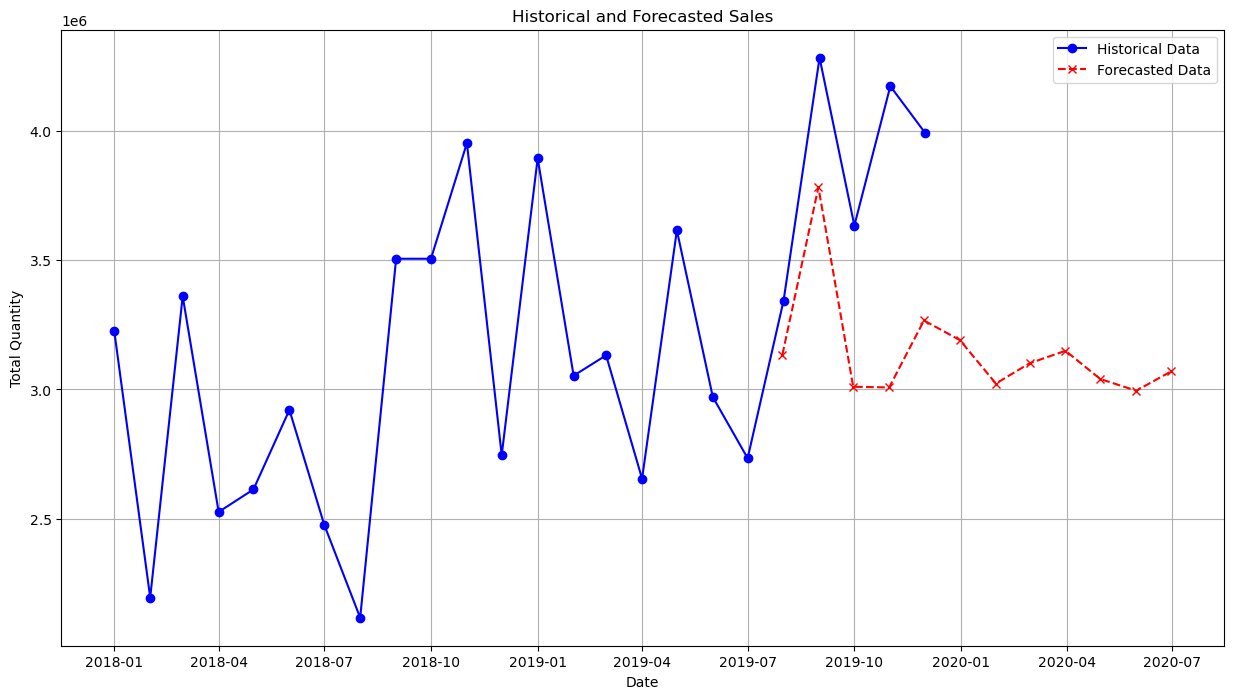

In [31]:
# Plot historical data with the forecast overlaid
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['TotalQuantity'], label='Historical Data', marker='o', color='blue')
plt.plot(forecast_df.index, forecast_df['TotalQuantity'], label='Forecasted Data', linestyle='--', marker='x', color='red')
plt.title('Historical and Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.legend()
plt.grid(True)
plt.show()

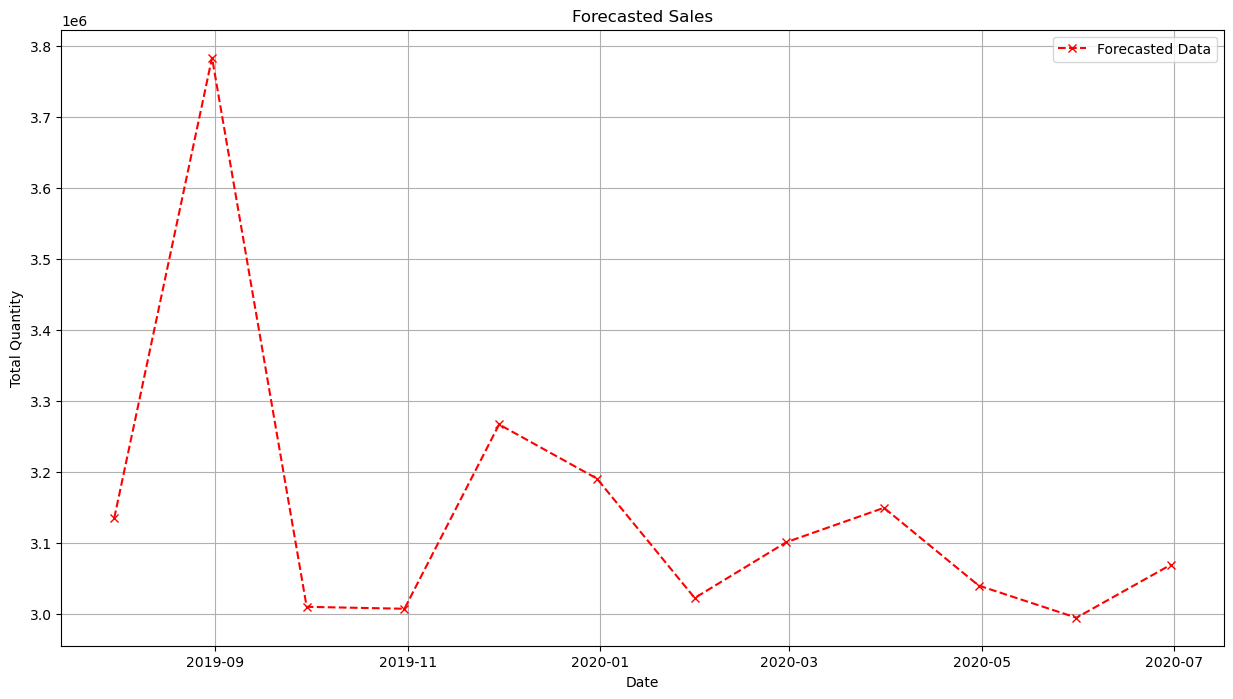

In [32]:
import matplotlib.pyplot as plt

# Assuming you have 'forecast_df' as your forecasted data DataFrame

# Forecasted data plot
plt.figure(figsize=(15, 8))
plt.plot(forecast_df.index, forecast_df['TotalQuantity'], label='Forecasted Data', linestyle='--', marker='x', color='red')

# Adding title and labels
plt.title('Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Total Quantity')

# Adding legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [38]:
import pandas as pd
import pyodbc

# Sample DataFrame creation, ensure 'Date' is datetime type
forecast_df = pd.DataFrame({
    'Date': pd.date_range(start='2024-01-01', periods=5, freq='M'),  # Creating example dates
    'TotalQuantity': [100, 150, 200, 250, 300]  # Example data
})

# Ensure the 'Date' column is of type datetime
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# Connect to SQL Server
server = 'DESKTOP-TOA5621\SQLEXPRESS'
database = 'SalesDWH'
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + database + ';Trusted_Connection=yes;')
cursor = conn.cursor()

# Insert data from DataFrame to SQL Server
insert_query = 'INSERT INTO ForecastSales (Date, TotalQuantity) VALUES (?, ?)'
for index, row in forecast_df.iterrows():
    # Use row['Date'] directly, ensuring it's the datetime object
    cursor.execute(insert_query, row['Date'], row['TotalQuantity'])

conn.commit()
cursor.close()
conn.close()


IntegrityError: ('23000', "[23000] [Microsoft][ODBC SQL Server Driver][SQL Server]Violation of PRIMARY KEY constraint 'PK__Forecast__77387D065864D318'. Cannot insert duplicate key in object 'dbo.ForecastSales'. The duplicate key value is (2024-01-31). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC SQL Server Driver][SQL Server]The statement has been terminated. (3621)")